In [1]:
from torchcnnbuilder.models import ForecasterBase
from torchcnnbuilder.preprocess.time_series import multi_output_tensor

import os
from datetime import datetime

from tqdm.notebook import tqdm

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
device = 'mps'
print(f'Calculating on device: {device}')

Calculating on device: mps


In [3]:
batch_size = 20
epochs = 300
learning_rate = 1e-2

data_freq = 7

In [4]:
x_virg = []
temp_ar = []
for file in os.listdir('/Users/kdduha/projects/osisaf/train'):
    date = datetime.strptime(file, 'osi_iceconc_%Y%m%d.npy')
    if date.year < 2013:
        array = np.load(f'/Users/kdduha/projects/osisaf/train/{file}')
        temp_ar.append(array)
        if len(temp_ar) == data_freq:
            temp_ar = np.array(temp_ar)
            temp_ar = temp_ar[-1]
            x_virg.append(temp_ar)
            temp_ar = []

In [5]:
for file in os.listdir('/Users/kdduha/projects/osisaf/test'):
    date = datetime.strptime(file, 'osi_iceconc_%Y%m%d.npy')
    if date.year < 2013:
        array = np.load(f'../../matrices/osisaf/test/{file}')
        temp_ar.append(array)
        if len(temp_ar) == data_freq:
            temp_ar = np.array(temp_ar)
            temp_ar = temp_ar[-1]
            x_virg.append(temp_ar)
            temp_ar = []

In [6]:
x_virg = np.array(x_virg)
x_virg.shape

(1200, 125, 125)

In [7]:
pre_history_size = 104
forecast_size = 52

In [8]:
dataset = multi_output_tensor(data=x_virg,
                             forecast_len=forecast_size,
                             pre_history_len=pre_history_size)

In [9]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [10]:
model = ForecasterBase(input_size=[125, 125],
                       n_layers=5,
                       in_channels=pre_history_size,
                       out_channels=forecast_size).to(device)

In [11]:
model

ForecasterBase(
  (convolve): Sequential(
    (conv 1): Sequential(
      (0): Conv2d(104, 116, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv 2): Sequential(
      (0): Conv2d(116, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv 3): Sequential(
      (0): Conv2d(128, 140, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv 4): Sequential(
      (0): Conv2d(140, 152, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv 5): Sequential(
      (0): Conv2d(152, 164, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (transpose): Sequential(
    (deconv 1): Sequential(
      (0): ConvTranspose2d(164, 162, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (deconv 2): Sequential(
      (0): ConvTranspose2d(162, 140, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (deconv 3): Sequential(
  

In [12]:
# добавить возможность смотреть слои и т.д.

In [ ]:
model.builder

In [13]:
from torchcnnbuilder.builder import EncoderBuilder

In [15]:
builder = EncoderBuilder(input_size=[125, 125])

In [16]:
d = builder.build_convolve_sequence(n_layers=5,
                                                        in_channels=pre_history_size,
                                                        ascending=True)

In [17]:
d

Sequential(
  (conv 1): Sequential(
    (0): Conv2d(104, 116, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv 2): Sequential(
    (0): Conv2d(116, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv 3): Sequential(
    (0): Conv2d(128, 140, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv 4): Sequential(
    (0): Conv2d(140, 152, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv 5): Sequential(
    (0): Conv2d(152, 164, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
)

In [18]:
builder.conv_layer_sizes

[[125, 125], (123, 123), (121, 121), (119, 119), (117, 117), (115, 115)]

In [20]:
d = builder.build_transpose_convolve_sequence(n_layers=5,
                                            in_channels=builder.conv_channels[-1],
                                            out_channels=52,
                                            ascending=True)

In [21]:
d

Sequential(
  (deconv 1): Sequential(
    (0): ConvTranspose2d(164, 162, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (deconv 2): Sequential(
    (0): ConvTranspose2d(162, 140, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (deconv 3): Sequential(
    (0): ConvTranspose2d(140, 118, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (deconv 4): Sequential(
    (0): ConvTranspose2d(118, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (deconv 5): Sequential(
    (0): ConvTranspose2d(96, 52, kernel_size=(3, 3), stride=(1, 1))
  )
  (resize): AdaptiveAvgPool2d(output_size=(125, 125))
)

In [22]:
builder.transpose_conv_layer_sizes

[(115, 115), (117, 117), (119, 119), (121, 121), (123, 123), (125, 125)]

In [15]:

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)
criterion = nn.L1Loss()

losses = []
epoches = []

for epoch in tqdm(range(epochs)):
    loss = 0
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)
        
        optimizer.zero_grad()
        outputs = model(train_features)
    
        l1_loss = criterion(outputs, test_features)
        train_loss = l1_loss
        
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(dataloader)
    scheduler.step(loss)
    
    losses.append(loss)
    epoches.append(epoch)
    
    tqdm.write("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

  0%|          | 0/300 [00:00<?, ?it/s]

epoch : 1/300, recon loss = 0.21468056
epoch : 2/300, recon loss = 0.21464311
epoch : 3/300, recon loss = 0.21463899
epoch : 4/300, recon loss = 0.21463627
epoch : 5/300, recon loss = 0.21463528
epoch : 6/300, recon loss = 0.21463485
epoch : 7/300, recon loss = 0.21463320


KeyboardInterrupt: 

In [ ]:
plt.plot(epoches, losses, label='Loss history')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('L1Loss')
plt.legend()
plt.show()

Вроде forward и backward работают адекватно, проверял модель с нормализацией (последний запуск) + без нормализации как в статье (первичный запуск), довел до эпох 40 и бросил 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
device = 'mps'
print(f'Calculating on device: {device}')

Calculating on device: mps


In [3]:
# setuping an absolute path to the project 
# not needed in case of `pip install`
%run -i tools/setup_env.py

In [4]:
%%capture
from tools.generating_time_series import synthetic_time_series

# the first object is an animation class of the whole time series
_, data = synthetic_time_series(num_frames=360)

In [5]:
train = data + data + data
test = data[:160]

In [6]:
print(f'Train dataset len: {len(train)}, One matrix shape: {train[0].shape}')
print(f'Test dataset len: {len(test)}, One matrix shape: {test[0].shape}')

Train dataset len: 1080, One matrix shape: (100, 100)
Test dataset len: 160, One matrix shape: (100, 100)


In [7]:
from torchcnnbuilder.preprocess.time_series import multi_output_tensor, single_output_tensor

In [8]:
train_dataset = multi_output_tensor(data=train,
                                    pre_history_len=120,
                                    forecast_len=40)

test_dataset = single_output_tensor(data=test, 
                                   forecast_len=40)

/Users/kdduha/projects/TorchCNNBuilder/torchcnnbuilder/preprocess/time_series.py:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1705477119555/work/torch/csrc/utils/tensor_new.cpp:278.)
  tensors = torch.Tensor(data)


In [9]:
for i, batch in enumerate(train_dataset):
    print(f'batch number: {i}',
          f'X shape: {batch[0].shape}\nY shape: {batch[1].shape}',
          sep='\n',
          end='\n\n')
    break
print(f'Dataset len (number of batches/X-windows): {len(train_dataset)}')

batch number: 0
X shape: torch.Size([120, 100, 100])
Y shape: torch.Size([40, 100, 100])

Dataset len (number of batches/X-windows): 920


In [10]:
for i, batch in enumerate(test_dataset):
    print(f'X shape: {batch[0].shape}\nY shape: {batch[1].shape}',
          end='\n\n')

print(f'Dataset len (number of batches/X-windows): {len(test_dataset)}')

X shape: torch.Size([120, 100, 100])
Y shape: torch.Size([40, 100, 100])

Dataset len (number of batches/X-windows): 1


In [11]:
from torchcnnbuilder.models import ForecasterBase

In [12]:
model = ForecasterBase(input_size=[100, 100],
                       in_channels=120,
                       out_channels=40,
                       n_layers=5,
                       normalization='batchnorm',
                       finish_activation_function=nn.ReLU(inplace=True)).to(device)

In [13]:
from tqdm.notebook import tqdm

In [17]:
epochs = 200
batch_size = 20

In [15]:
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [16]:
from pytorch_msssim import ssim

In [ ]:
optimizer = optim.AdamW(model.parameters(), eps=1e-3)
criterion = nn.L1Loss()

losses = []
epoches = []

for epoch in tqdm(range(epochs)):
    loss = 0
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)
        
        optimizer.zero_grad()
        outputs = model(train_features)
    
        #l1_loss = criterion(outputs, test_features)
        ssim_loss = 1 - ssim(outputs, test_features, data_range=1, size_average=True)
        train_loss = ssim_loss 
        
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(dataloader)
    
    losses.append(loss)
    epoches.append(epoch)

    if epoch % 10 == 0 or epoch - 1 == epochs:
        tqdm.write("epoch : {}/{}, recon loss = {:.8f}".format(epoch+1, epochs, loss))

  0%|          | 0/200 [00:00<?, ?it/s]

epoch : 1/200, recon loss = 0.37984718
epoch : 11/200, recon loss = 0.14754021
epoch : 21/200, recon loss = 0.14049553
epoch : 31/200, recon loss = 0.13961059
epoch : 41/200, recon loss = 0.12761861
epoch : 51/200, recon loss = 0.11762807
epoch : 61/200, recon loss = 0.11460100
epoch : 71/200, recon loss = 0.10941182
epoch : 81/200, recon loss = 0.10703735
epoch : 91/200, recon loss = 0.10159456
epoch : 101/200, recon loss = 0.09564571
epoch : 111/200, recon loss = 0.09114790
epoch : 121/200, recon loss = 0.08683856
epoch : 131/200, recon loss = 0.08543030
epoch : 141/200, recon loss = 0.08551920
epoch : 151/200, recon loss = 0.07997250
epoch : 161/200, recon loss = 0.07623548


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

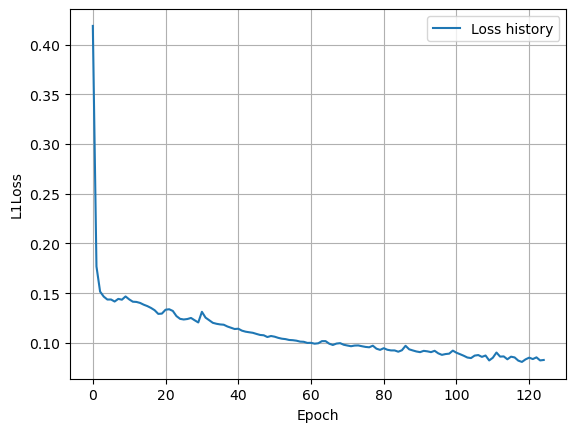

In [23]:
plt.plot(epoches, losses, label='Loss history')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('L1Loss')
plt.legend()
plt.show()

In [24]:
with torch.no_grad():
    model.eval()
    for X, Y in test_dataset:
        X = X[None, :].to(device)
        Y = Y[None, :].to(device)
            
        outputs = model(X)
        
        l1_val = criterion(outputs, Y)
        ssim_val = ssim(outputs, Y, data_range=1, size_average=False)
        
        print(l1_val)
        print(ssim_val)

tensor(0.0305, device='mps:0')
tensor([0.9064], device='mps:0')


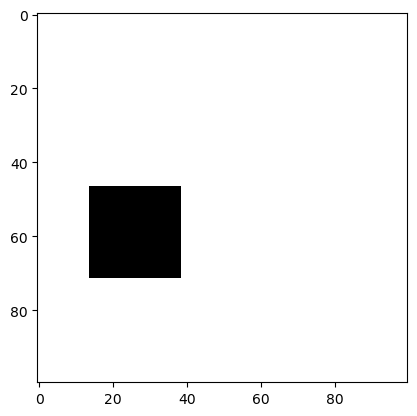

In [42]:
plt.imshow(1 - Y[0].cpu()[35], cmap='gray')

In [52]:
Y[0].cpu().numpy()[36].mean()

0.0625

In [53]:
outputs[0].detach().cpu().numpy()[36].mean()

0.0

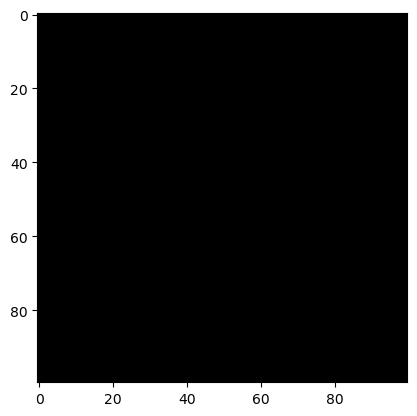

In [44]:
plt.imshow((1-outputs[0].detach().cpu().numpy()[36]), cmap='gray')

In [27]:
from tools.generating_time_series import save_gif

In [43]:
%%capture
save_gif(matrices=outputs[0].detach().cpu().numpy() > 0.5,
         name='predict')

In [30]:
%%capture
save_gif(matrices=test[-40:],
         name='test')

In [23]:
%%capture
save_gif(matrices=train,
         name='train')